## Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.
***

**__Table of Contents__**

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
critics = pd.read_csv('critics.csv')
# select all notnull() in critics.quote
critics = critics[~critics.quote.isnull()] 
display(critics.head())
print('"critics df shape: {}'.format(critics.shape))

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


"critics df shape: (15561, 8)


## Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


Below, I will create a copy of the critics dataframe and alter this copy. For the column "fresh" which represents essentially positive or negative review type left by the critic. I will set this column equal to ONLY
the positive or "fresh" reviews as this si the data of interest at this particular phase. You could of course get the data of interest from fresh column without altering original "fresh column, and in effect where no copy is needed. I choose to proceed with process in former description because i feel its more explicit and intuitive if I or someoene else down the road were to come to the code later.

In [4]:
print('Categories in critics.fresh (original dataframe)\n\n{}\n\n'.format(critics.fresh.unique()))
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'  # select only positive reviews

Categories in critics.fresh (original dataframe)

['fresh' 'rotten' 'none']




In [5]:
data = critics.copy()
grp = data.groupby('critic') # groupby object, on critic column
display(data.fresh.value_counts())
# data.loc[data.fresh.values == 'none', ['fresh']] == np.nan
# data.fresh.astype('category')
grp_fromdf = df.groupby('critic') # groupby object, on critic column

#for key, item in grp:
    #print(grp.get_group(key), '\n\n') # this prints data per critic, for all critics

fresh     9482
rotten    6052
none        27
Name: fresh, dtype: int64

In [6]:
means = grp_fromdf.fresh.mean()     # average freshness for each critic
counts = grp_fromdf.critic.count()  # number of reviews by each critic
print('REVIEW-COUNT PER CRITIC:\n\nTOP 10:\
\n\n{}\n\nBOTTOM 10\n\n{}\n\n'.format(counts.sort_values(ascending=False)[:10],
                                      counts.tail(10).sort_values(ascending=True)))

REVIEW-COUNT PER CRITIC:

TOP 10:

critic
Roger Ebert           1132
James Berardinelli     804
Janet Maslin           515
Variety Staff          430
Jonathan Rosenbaum     412
Desson Thomson         391
Geoff Andrew           349
Dave Kehr              338
Kenneth Turan          279
Mick LaSalle           273
Name: critic, dtype: int64

BOTTOM 10

critic
Vic Vogler              1
Walter V. Addiego       2
Whittaker Chambers      3
William Goss            3
Whitney Willaims        4
William Brogdon         4
Walter Goodman          7
Wesley Morris          15
Wally Hammond          34
Vincent Canby         217
Name: critic, dtype: int64




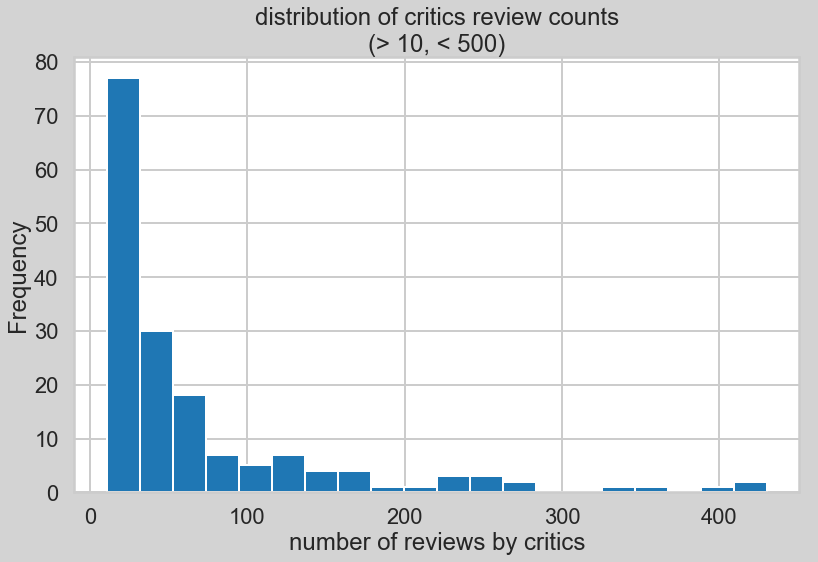

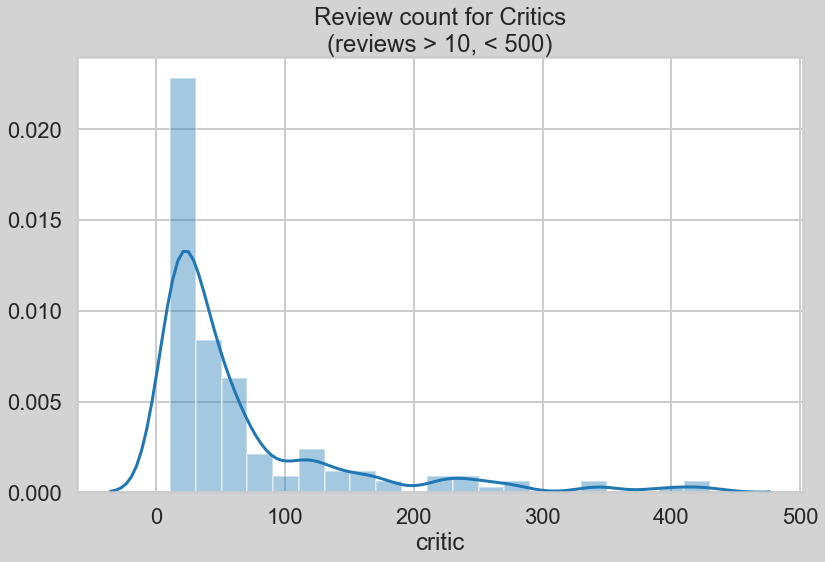

In [7]:
# review counts between 10 and 500: determined from top10/bottom 10 list above
counts_subset=counts.loc[(counts > 10) & (counts < 500)]

#plot trimmed data for better visualization of distribution
plt.figure(facecolor='lightgrey', figsize=(13,8))
plt.hist(counts_subset, bins=20)
plt.title('distribution of critics review counts\n(> 10, < 500)')
plt.xlabel('number of reviews by critics')
plt.ylabel('Frequency'); plt.show()

plt.figure(facecolor='lightgrey', figsize=(13,8))
chart = sns.distplot(counts_subset)
plt.title('Review count for Critics\n(reviews > 10, < 500)');

We can see from the plot above, that some critics have a extreme number of movie reviews compared to the rest creating a right skew to the distribution.

number of critics w/ > 100 movie reviews = 37

AVERAGE RATINGS

critic
Joe Baltake           0.811404
Kevin Thomas          0.806897
Richard Schickel      0.737705
Richard Corliss       0.728070
Variety Staff         0.725581
Janet Maslin          0.708738
Geoff Andrew          0.707736
Bosley Crowther       0.695035
Todd McCarthy         0.683258
Roger Ebert           0.673145
Peter Travers         0.666667
Michael Wilmington    0.660494
John Hartl            0.655172
Lisa Schwarzbaum      0.655172
Vincent Canby         0.645161
Edward Guthmann       0.638655
Emanuel Levy          0.629630
Peter Stack           0.620438
Derek Adams           0.615894
Susan Stark           0.611429
Jay Carr              0.603604
James Berardinelli    0.603234
Kenneth Turan         0.602151
Jonathan Rosenbaum    0.599515
Owen Gleiberman       0.595142
Dave Kehr             0.591716
Desson Thomson        0.588235
Jeff Millar           0.554878
Mick LaSalle          0.538462
Hal Hinson            0.530055

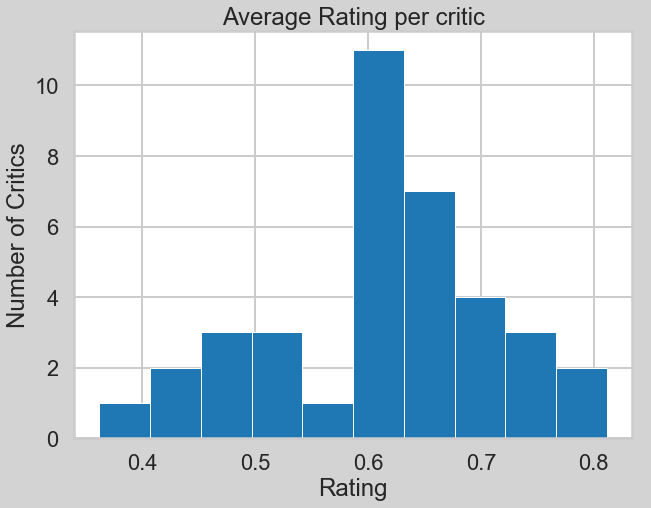

In [8]:
avg_rating = means[counts > 100]
print('number of critics w/ > 100 movie reviews = {}\n'.format(len(avg_rating)))
print('AVERAGE RATINGS\n\n{}'.format(avg_rating.sort_values(ascending=False)))

plt.figure(facecolor='lightgrey', figsize=(10,7.5))
means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.title("Average Rating per critic")
plt.xlabel("Rating")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

We see there are about as many critics who give more "fresh" ratings than "rotten" as there are who do the opposite. The distribution looks normal.

## Vector space model & search engine

>A **vector space model** is an algebraic model, involving two steps, in first step we represent the text documents into vector of words and in second step we transform to numerical format so that we can apply any text mining techniques such as information retrieval, information extraction,information filtering etc." - [source](http://www.dataperspective.info/2017/11/information-retrieval-document-search-using-vector-space-model-in-r.html)

>"A **vector space search** involves converting documents into vectors. Each dimension within the vectors represents a term. If a document contains that term then the value within the vector is greater than zero." - [source](http://blog.josephwilk.net/projects/building-a-vector-space-search-engine-in-python.html)

>"**Vector-space search engines** use the notion of a term space, where each document is represented as a vector in a high-dimensional space. There are as many dimensions as there are unique words in the entire collection." - [source](http://blog.josephwilk.net/projects/building-a-vector-space-search-engine-in-python.html)

**Define the vector**

Let us define the vector derived from document $d$ as $\bar V(d)$.

 - Each document is treated as a vector containing information about the words contained in it. 
 
 - Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. 
  
 - Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

**Define the vocabulary**

The vocabulary is a union of words seen in all documents. We associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``{0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine}``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### Vector Space and Search Engine - In Code

Text Analysis and classification is a major application field for machine learning algorithms. However the raw data or raw text documents, are a sequence of symbols with variable length. The raw data in this form cant be interpreted by a machine learning model. The algorithm is expecting feature vectors of numerical type of a fixed size. Because of this we need to **transform our raw text data into numerical data using CountVectorizer which converts our text into a matrix of token counts

_considerations when working with scikit-learn_:
- expects and assumes all values to have meaning
- does not work with missing values
- expects numerical feature vectors with a fixed size

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0)

# example list of text data
text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}\n".format('\n'.join(text)))

# build the vocabulary with fit()
vectorizer.fit(text)
print('(1). CountVectorizer().fit(raw_text) returns:\n\n\
    {}\n\n'.format(vectorizer.fit(text)))

# explore the vocabulary where each word of vocab reprented per column
_='(1.1) Can also return vocabulary of the raw text data with:\n\n\
    CountVectorizer().fit(raw_text).get_feature_names()\n\n\
    #output\n    {}\n\n'; print(_.format(vectorizer.get_feature_names()))

# Transform text (train-set) into a "document-term matrix"
# ... or "bag of words"
x_as_doc_term_matrix = vectorizer.transform(text)
_='(2) Transform text data into document-term matrix or bag-of-words:\n\n\
  #syntax\n  CountVectorizer().transform(raw_text)\n\n\
  #output\n{}'; print(_.format(x_as_doc_term_matrix))

display(x_as_doc_term_matrix)

# Intuition for display above
print('Intuition for the document-term matrix (row-column matrix above).\n\
 - documents == rows\n\
 - terms == columns\n\
 - 3 rows because there are 3 documents\n\
 - 4 columns because we have 4 terms (words) learned from "fit" stage above\n\n')

_=' ... you can check the type of the sparse matrix or document-term matrix by \
wrapping it with "type" function:\n\n\  #syntax\n  type(x_as_doc_term_matrix)\n\n  #output\n  {}\n\n'
print(_.format(type(x_as_doc_term_matrix)))

Original text is
Hop on pop
Hop off pop
Hop Hop hop

(1). CountVectorizer().fit(raw_text) returns:

    CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


(1.1) Can also return vocabulary of the raw text data with:

    CountVectorizer().fit(raw_text).get_feature_names()

    #output
    ['hop', 'off', 'on', 'pop']


(2) Transform text data into document-term matrix or bag-of-words:

  #syntax
  CountVectorizer().transform(raw_text)

  #output
  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 1)	1
  (1, 3)	1
  (2, 0)	3


<3x4 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

Intuition for the document-term matrix (row-column matrix above).
 - documents == rows
 - terms == columns
 - 3 rows because there are 3 documents
 - 4 columns because we have 4 terms (words) learned from "fit" stage above


 ... you can check the type of the sparse matrix or document-term matrix by wrapping it with "type" function:

\  #syntax
  type(x_as_doc_term_matrix)

  #output
  <class 'scipy.sparse.csr.csr_matrix'>




**Quick summary of CountVectorizer** 
(_used in above example_)

- **_CountVectorizer().fit(xtrain)_**: Tthe vectorizor will learn the vocabulary on training data

- **_CountVectorizor().transform(xtrain)_**: The vectorizor builds the document-term matrix from training data (above line).

- **_CountVectorizer().transform(test)_**: The vectorizer build the document-term matrix from the test data and ignores tokens or words it hasnt seen before.

In [10]:
# Convert doc-term matrix (sparse matrix) into dense matrix or "text-vector"
x = x_as_doc_term_matrix.tocsc() # Countvectorizer uses a sparse matrix to save memory
                                 # some versions of sklearn return COO format
                                 # ... .toarray(), or np.array(X), 
print("(3) Convert the document-term matrix to a dense matrix or text-vector:\n\n\
 #syntax\n x_as_doc_term_matrix.toarray()\n\n #output\n {}\n\n".format(x))

(3) Convert the document-term matrix to a dense matrix or text-vector:

 #syntax
 x_as_doc_term_matrix.toarray()

 #output
   (0, 0)	1
  (1, 0)	1
  (2, 0)	3
  (1, 1)	1
  (0, 2)	1
  (0, 3)	1
  (1, 3)	1




**Vectorization**
 - Convert collection of text documents called a **Corpus** into numerical feature vectors. 
 - Documents are described by word occurrences ignoring relative position of words in the document.

**The strategy below** 
 - (tokenization, counting and normalization) is called the Bag of Words or "Bag of n-grams" representation. 

In [11]:
# vocabulary and document-term matrix together
print('(4) CORPUS OF DOCUMENTS (below):\n\
  - represented by a matrix\n\
  - where one row or sample per one document\n\
  - where one column per token (e.g. word) occurring in the corpus.')

display(pd.DataFrame(x_as_doc_term_matrix.toarray(),
             columns=vectorizer.get_feature_names()))

print('  INTUITION: columns/features & row/samples:\n\
   - feature == individual token occurance frequency\n\n\
   - rows/samples are defined as documents where:\n\
     document == a vector of token frequencies (a multivariate sample)')

(4) CORPUS OF DOCUMENTS (below):
  - represented by a matrix
  - where one row or sample per one document
  - where one column per token (e.g. word) occurring in the corpus.


,hop,off,on,pop
0,1,0,1,1
1,1,1,0,1
2,3,0,0,0


  INTUITION: columns/features & row/samples:
   - feature == individual token occurance frequency

   - rows/samples are defined as documents where:
     document == a vector of token frequencies (a multivariate sample)


#) Manual vectorizer function for features and labels

In [12]:
def VectorizeXY(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y

"""
#Intuition for y:
(critics.fresh == 'fresh')                         # returns pd.Series of TRUE/FALSE (discrete boolean) values
(critics.fresh == 'fresh').astype(np.int)          # converts to 1/0 (int32)
(critics.fresh == 'fresh').astype(np.int).values   # convert to array where .values == wrapping w/ array function """

vectorized_X, vectorized_y = VectorizeXY(critics)

## **Naive Bayes** - (_Intuition_)

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.



___
### **Multinomial Baive Bayes and (other) Likelihood Functions**

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

## **Naive Bayes** (_in action_)
1. split the data set into a training and test set
2. Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
3. train the classifier over the training set and test on the test set
4. print the accuracy scores for both the training and the test sets

### **Data preperation** - _define x and y_

In [13]:
print('Calling, ".values.astype(np.int)", on our target "df.fresh"\
converts original yes/no boolean values into 1/0 numerical type.')

train_df = pd.DataFrame()
# Establish x: text features
train_df['x'] = df['quote']
# Establish y: target labels
train_df['y'] = df['fresh'].values.astype(np.int)

print('null-value check:\n{}'.format(train_df.isnull().sum()))
train_df.head()

Calling, ".values.astype(np.int)", on our target "df.fresh"converts original yes/no boolean values into 1/0 numerical type.
null-value check:
x    0
y    0
dtype: int64


,x,y
1,"So ingenious in concept, design and execution ...",1
2,The year's most inventive comedy.,1
3,A winning animated feature that has something ...,1
4,The film sports a provocative and appealing st...,1
5,"An entertaining computer-generated, hyperreali...",1


### **Train-test-split**

- Split the dataset into training and validation sets so that we can train and test classifier.
___
**WRONG PROCESS: Vectorize before train-test-split**

 - If we vectorize our data before splitting our bag-of-words (document-term matrix) this would create a situation where every single word (feature) would be included in both training and testing sets. This would create a case of always seeing words/features that the model hasn't ever seen before. Remember the goal of the train-test-split is to establish a hold-out set we can validate models and evaluate their predictions on un-seen data and the goal of this evaluation essentially is to simulate future events. Therefore if the model is always seeing features it should not ever actually see, this is an inaccurate simulation of the real-world.

___

**CORRECT PROCESS: Split before using a vectorizer**

 - This will give us an accurate simulation of new, real-world data of the future and contain words un-seen by model previously.
___
**Maximize model learning**

 - After you train your data and chose the best model, you then train on all data prior to making predictions

In [14]:
pd.set_option('display.max_rows', 0)
from sklearn.model_selection import train_test_split

print('TARGET BEFORE SPLIT:\nfresh == True ("1"):  total = {}'.format(train_df[train_df['y'] == 1].shape[0]))
print('fresh == False ("0"): total = {}\n'.format(train_df[train_df['y'] == 0].shape[0]))

# split the dataset into training and validation datasets 
train_x, test_x, train_y, test_y = train_test_split(train_df['x'], train_df['y'])

#print('After Splitting:\n\ny-train size: {}'.format(len(train_y)))
print('AFTER SPLITTING:\ny-train label counts:\n{}\n'.format(train_y.value_counts()))
#print('y-test size: {}\n'.format(len(test_y)))
print('y-test label counts:\n{}'.format(test_y.value_counts()))

TARGET BEFORE SPLIT:
fresh == True ("1"):  total = 9482
fresh == False ("0"): total = 6079

AFTER SPLITTING:
y-train label counts:
1    7088
0    4582
Name: y, dtype: int64

y-test label counts:
1    2394
0    1497
Name: y, dtype: int64


### **Encode target-labels with LabelEncoder**
- Encode our target column so that it can be used in machine learning models.

 - _(as mentioned, we've already done so manually, below is for example only)_

In [15]:
from sklearn.preprocessing import LabelEncoder

# label encode the target variable w/ LabelEncoder()
# encoder = LabelEncoder()
# train_y_encoded = encoder.fit_transform(train_y)
# test_y_encoded = encoder.fit_transform(test_y)
# print('y-train after encoding: {}\ny-test after encoding: {}'.format(train_y_encoded, test_y_encoded))

### **Feature Engineering via Vectorization**
Below will be multiple vecorization methods for transforming raw text data into feature vectors. As an effect, new features are created. Vectorization is **_only for the features (xtrain, and xtest sets), not the target (ytrain and ytest)._**

#### _Count Vectors as features_
#### _TF-IDF Vectors as features_
#### Implementing Pipelines

    FOR:
    -Word level
    -N-Gram level
    -Character level

**5.2.1** _**CountVectorizer()**_

_Count Vectors as features. Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document._

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Create a count vectorizer object 
CountVect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
# Train Count Vectorizer on ALL of our text data: x
CountVect.fit(train_df['x'])
# A sparse matrix of [n_samples, n_features]: "Document-term matrix", or  "bag-of-words"
xtrain_countVect =  CountVect.transform(train_x)
xtest_countVect =  CountVect.transform(test_x)
# Instantiate a Multi-Nomial Naive Bayes Classifier
model = MultinomialNB()
# Train model on train sets
model.fit(xtrain_countVect, train_y)
# predict
predictions = model.predict(xtest_countVect)

In [32]:
# evaluate prediction accuracy of model
model_acc_score = round(accuracy_score(test_y, predictions),4)
print('Accuracy score w/ Count-Vectors as features: {}\n'\
      .format(model_acc_score))
model_acc_score

Accuracy score w/ Count-Vectors as features: 0.781



0.781

In [81]:
test_y.sort_index()

12       1
14       1
15       1
41       1
49       0
52       1
55       0
76       1
81       0
85       1
86       1
91       1
        ..
27561    1
27570    1
27573    0
27574    1
27575    0
27576    0
27580    0
27597    1
27603    0
27605    1
27609    1
27616    1
Name: y, Length: 3891, dtype: int32

In [ ]:
# a = pd.Series(test_y.sort_index().index)
# #np.vstack(a.values)
# # b = pd.Series(predictions).sort_index()
# #b
# c = pd.concat([a, b], axis=1)
# c.columns = ['index', 'predictions']
# d = np.vstack(test_y.sort_index().values)
# d.reshape(3891,)
# d.dtype
# e = pd.concat([c.index,c.predictions, np.array(pd.Series(d).values)], axis=1)
# e
# #e.columns = ['index', 'true', 'predictions']

In [73]:
print('all reviews "fresh col"\n{}'.format((critics['fresh'].value_counts())))
print('all reviews {}\n'.format(9482+6052))

print('test_y\n{}'.format((test_y.value_counts())))
print('test_y total {}\n'.format(2394+1497))

print('predictions results\n{}'.format(pd.Series(predictions).value_counts()))

print('predictions total {}'.format(2580+1311))
print('accuracy {}'.format(1311/1497))

all reviews "fresh col"
fresh     9482
rotten    6052
none        27
Name: fresh, dtype: int64
all reviews 15534

test_y
1    2394
0    1497
Name: y, dtype: int64
test_y total 3891

predictions results
1    2580
0    1311
dtype: int64
predictions total 3891
accuracy 0.875751503006012


In [18]:
# Understand class distribution and consider possible class skew
fresh_ = test_y.value_counts().values[0]
rotten_ = test_y.value_counts().values[1]
print('Check for Skewness of target distribution:\n\
  "fresh" count: {}\n\
 "rotten" count: {}\n'.format(fresh_, rotten_))

# for multi-class classification problems
# evaluate model accuracy for always predicting "fresh"

fresh_accuracy = round(fresh_ / len(test_y),4)
print('fresh (1) accuracy:', fresh_accuracy)

# evaluate model accuracy for always predicting "rotten"
rotten_accuracy = round(rotten_ / len(test_y),4)
print('rotten (0) accuracy:', rotten_accuracy)

Accuracy score w/ Count-Vectors as features: 0.781

Check for Skewness of target distribution:
  "fresh" count: 2394
 "rotten" count: 1497

fresh (1) accuracy: 0.6153
rotten (0) accuracy: 0.3847


In [19]:
print('Above, we see our accuracy ({}) is higher than the "fresh" accuracy score of {}'.format(model_acc_score, fresh_accuracy))

Above, we see our accuracy (0.781) is higher than the "fresh" accuracy score of 0.6153


In [31]:
print('train_df[\'y\'] total number of rotten reviews = {}'.format(train_df[train_df.y == 0].size))#head()#test_y
print('train_df[\'y\'] total number of fresh reviews = {}'.format(train_df[train_df.y == 1].size))

print('{} "rotten" and {} "fresh" reviews contained in y-validation set ("test_y")'.format(test_y.value_counts()[0], test_y.value_counts()[1]))
# ... make note of the reverse order compared to above depending on executing of the query
# ... run commented-out code below for demonstration
display(test_y.value_counts().values[0]) # where "[0]" fresh reviews 
display(test_y.value_counts().values[1]) ##where "[1]" rotten reviews

train_df['y'] total number of rotten reviews = 12158
train_df['y'] total number of fresh reviews = 18964
1497 "rotten" and 2394 "fresh" reviews contained in y-validation set ("test_y")


2394

1497

#### evaluate and visualize model performance


In [21]:
# Confusion matrix or error matrix format
err_matrx_acronyms = np.array([['TN', 'FP', 'FN', 'TP']]).reshape(2,2)
#print('initial dtype of np.array([["TN", "FP", "FN", "TP"]] = {}'.format(str(confusion_matrix_labels.dtype).strip("\'\<\'")))
print('Confusion or Error Matrix format (acronyms for labels):\n{}'.format(err_matrx_acronyms))# print('reshape to,\n',err_matrx_acronym)

Confusion or Error Matrix format (acronyms for labels):
[['TN' 'FP']
 ['FN' 'TP']]


In [30]:
from sklearn.metrics import confusion_matrix

# tally total correct vs incorrect label predictions and print confusion or error matrix results ("actual" vs "predicted")
error_matrix_results = confusion_matrix(test_y, predictions)
print('\n"Confusion or error matrix results:\n{}'.format(error_matrix_results))
confusion_matrix(test_y, predictions)

rotten_counts = pd.Series(error_matrix_results[0], name="rotten")
fresh_counts = pd.Series(error_matrix_results[1], name="fresh")
confusion_matrix_df = pd.DataFrame(data=pd.concat([fresh_counts, rotten_counts], axis=1), index=['TP_preds', 'FP_preds'], columns=['TN_preds', 'FN_preds'])
confusion_matrix_df
# print('h-stack: {}'.format(np.hstack(error_matrix_results)))
# print('v-stack: {}'.format(display(np.vstack(error_matrix_results))))
# print('"pop": {}\n'error_matrix_results.pop())
# print('"ravel": {}\n'error_matrix_results.ravel())
# print('"swapaxes": {}\n'.format(error_matrix_results.swapaxes()))
# print('T {}\n'.format(error_matrix_results.T))


"Confusion or error matrix results:
[[ 978  519]
 [ 333 2061]]


,TN_preds,FN_preds
TP_preds,NaN,NaN
FP_preds,NaN,NaN


In [29]:
# confusion matrix annotation: pred-counts + acronym ("valAndAcronym")
confusion_matrix_outcomes0 = [(str(total)+' ('+ err_matrx_acronym +')' for total in error_matrix_results)] # needs 2-b array-like or str for correct matrix-func execution
# confusion_matrix_outcomes0 = np.diagonal(np.matrix(confusion_matrix_outcomes0))#, (2,2))#.reshape(2,2)
#plt.plot(np.ndarray(str(confusion_matrix_outcomes0)))
#confusion_matrix_outcomes = confusion_matrix_valAndAcronym.reshape(2,2)
#print('\n\nThe Object of interest (for heatmap annotation): Results alongside the acronyms:\n{}'.format(confusion_matrix_valAndAcronym))

[<generator object <genexpr> at 0x000000AE1C2AFE08>]

In [192]:
# totals = [total for total in error_matrix_results]
# totals
#str(total)+' ('+ err_matrx_acronym +')' for total in error_matrix_results

total
#total err_matrx_acronym for total in error_matrix_results

# # we need to deal with dtype displayed earlier for our array of confusion-matrix annotations we want
# print('initial dtype of np.array([["TN", "FP", "FN", "TP"]] = {}'.format(str(confusion_matrix_labels.dtype).strip("\'\<\'")))

# dt = np.dtype('>i4')
# dt.byteorder
# dt.itemsize
# dt.name
#dt.type is np.int32

#confusion_matrix_outcomes1 = 
# display(confusion_matrix_outcomes1)

# confusion_matrix_valAndAcronym = np.diagonal(np.matrix(confusion_matrix_outcomes1))
# confusion_matrix_valAndAcronym = confusion_matrix_valAndAcronym.reshape(2,2)
# print('...\n\nThe Object of interest (for heatmap annotation): Result alongside the acronym:\n{}'.format(confusion_matrix_valAndAcronym))

array([ 185, 2221], dtype=int64)

In [ ]:
# confusion_matrix_labels[0] = 'TN'; confusion_matrix_labels[1] = 'FP'
# confusion_matrix_labels[2] = 'FN'; confusion_matrix_labels[3] = 'TP'
# err_matrx_acronym = confusion_matrix_labels.reshape(2,2)


In [ ]:
tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel() 
results = [tn, fp, fn, tp]
results = pd.Series(results, index=['True Negative','False Positive',
                                    'False Negative','True Positive'])
print('\nResults with "labels" (index-labels):\n{}\n'.format(results))

In [113]:
# confusion matrix annotation: labels + acronym ("fullLabels")
conf_matrix_fullLabels = confusionMatrix_idxlabels+' ('+ err_matrx_acronym +')'
print('(index) labels + acronyms:\n{}\n'.format(conf_matrix_fullLabels))

intuition = results.index
print('Intuition:\n\
{} = correct prediction of the negative class (0: "rotten")\n\
{} = incorrect prediction of the positive class (1: "fresh")\n\
{} = incorrect prediction of the negative class (0: "rotten")\n\
{} = correctl prediction of the positive class (1: "fresh")\n'.format(definitions[0], definitions[1], 
                                                                    definitions[2], definitions[3]))

NameError: name 'confusionMatrix_idxlabels' is not defined

confusion matrix data:
 [[ 962  549]
 [ 342 2038]]


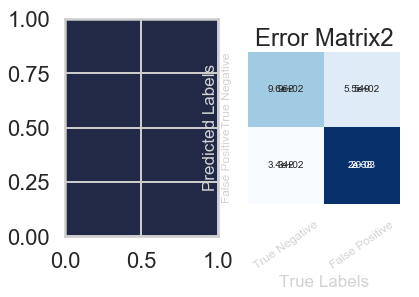

In [483]:
print('confusion matrix data:\n',data_)
data_.
# ax.invert_xaxis(), ax.invert_yaxis() # invert for clean look
# ax.xaxis.tick_top()         # move x-axis labels above chart
# ax.yaxis.tick_right()     # move y-axis labels to right side
# ax.set_title('Correlations among variables', pad=65, loc='center', size=35)

#figure and axes
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, frameon=False) # figsize=(7,7)

# chart1
ax[0] = sns.heatmap(data_, cbar=False, square=True, annot=True, cmap="Blues") #xticklabels=results[2:4].index, yticklabels=results[0:2].index))
ax[0].set_title('Error Matrix1')#, color='lightgrey')#, pad=30)
# x axis adjustments
ax[0].set_xlabel('True Labels', color='lightgrey', fontdict={'size':17})
ax[0].set_xticklabels(chart.get_yticklabels(), color='lightgrey', 
                      fontdict={'fontsize': 12,'fontweight': 5,'ha': 'center', 'rotation':35}) #, labelpad=20
# y axis adjustments
ax[0].set_ylabel('Predicted Labels', color='lightgrey', fontdict={'size':17}) #  labelpad=20,
ax[0].set_yticklabels(chart.get_yticklabels(), color='lightgrey',
                      fontdict={'fontsize': 12,'fontweight': 5, 'va': 'center'})

""" fix scientific annotation and resize heatmap in chart 2 below:
     -if annot=True, then fmt='.2g' is default. To rid scientific vals set fmt='g' """

# chart2
ax[1] = sns.heatmap(data_, cbar=False, square=True, annot=True, fmt='g', cmap="Blues")
                            #xticklabels=results[2:4].index, yticklabels=results[0:2].index))
#chart2.axis('auto')
ax[1].set_title('Error Matrix2')#, color='lightgrey')#, pad=30)
# x axis adjustments
ax[1].set_xlabel('True Labels', color='lightgrey')#, labelpad=40)
ax[1].set_xticklabels(chart.get_yticklabels(), color='lightgrey', fontdict={'ha': 'center'}) # 'fontsize': 12,'fontweight': 10,
# y axis adjustments
ax[1].set_ylabel('Predicted Labels')#, color='lightgrey', labelpad=40)
ax[1].set_yticklabels(chart.get_yticklabels(), color='lightgrey',fontdict={'va': 'center'}); #'fontsize': 17.5,'fontweight': 10,

In [25]:
# formatting styles for heatmap (2,2 matrix value and labels)
print(
    '1 \n{}\n\n\
    2 \n{}\n{}\n\
    3 \n{}\n{}\n\
    4 \n{}\n\n\
    5 \n{}\n\n\
    6 \n{}\n{}\n\
    7 \n{}\n\n\
    8 \n{}\n\
    '.format(
    confusionMatrix_valsObjFlat,
    confusionMatrix_vals,confusionMatrix_vals.dtype,
    confusionMatrix_valsObj,confusionMatrix_valsObj.dtype,
    confusion_matrix_labels,
    confusionMatrix_acronymFlat,
    confusionMatrix_acronym,confusionMatrix_acronym.dtype,
    results.index.values,
    results.index.value_counts()))

NameError: name 'confusionMatrix_valsObjFlat' is not defined

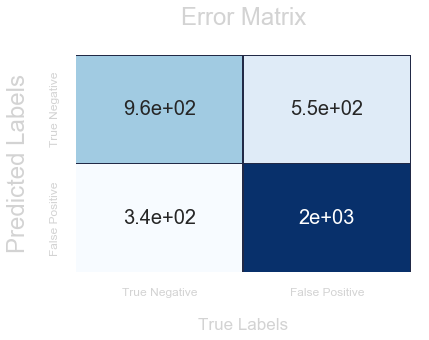

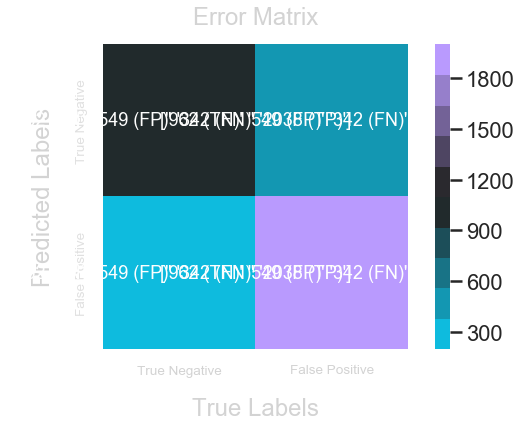

In [551]:
# mask redundancy if many classes/features
#mask_lower = np.triu(collinear_search) w/ "mask=mask_lower" in heatmap
fig, ax = plt.subplots(frameon=False)
chart1 = sns.heatmap(data_, cbar=False, annot=True, annot_kws={'size':20}, cmap="Blues",
                     linewidths=.5, linecolor= '#212946',
                     xticklabels=results[2:4].index, yticklabels=results[0:2].index)
chart1.set_title('Error Matrix', color='lightgrey', pad=30)
# x axis adjustments
chart1.set_xlabel('True Labels', color='lightgrey', labelpad=20, fontdict={'size':17})
chart1.set_xticklabels(chart.get_yticklabels(), color='lightgrey', 
                      fontdict={'fontsize': 12,'fontweight': 5,'ha': 'center', 'rotation':0})
# y axis adjustments
chart1.set_ylabel('Predicted Labels', color='lightgrey', labelpad=20)# fontdict={'size':17})
chart1.set_yticklabels(chart.get_yticklabels(), color='lightgrey', rotation=90,
                      fontdict={'fontsize': 12,'fontweight': 5, 'va': 'center'})
plt.show()



# for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
#     plt.rcParams[param] = '#212946'

# -----------------------CHART2--------------------------------------
fig, ax = plt.subplots(figsize=(7,7), frameon=False)
# manual color adjustments
color = sns.diverging_palette(220, 276, s=99, l=70, sep=14, n=10, center="dark")
text = np.array([confusion_matrix_valAndAcronym[0,0], confusion_matrix_valAndAcronym[0,1],
        confusion_matrix_valAndAcronym[1,0], confusion_matrix_valAndAcronym[1,1]])
text
chart2 = sns.heatmap(data_, annot=True, annot_kws={'size':18, 'alpha' : 2, 'text': text},
                     fmt='g', square=True, cmap=color, cbar=True, cbar_kws={'pad' : .07, 'shrink' : .8},
                     vmin=200, vmax=2000, xticklabels=results[2:4].index, yticklabels=results[0:2].index)
#chart2.axis('auto')
chart2.set_title('Error Matrix', color='lightgrey', pad=20, loc='center', fontdict={'va':'baseline'})
# x axis adjustments
chart2.set_xlabel('True Labels', color='lightgrey', labelpad=20)
chart2.set_xticklabels(chart.get_yticklabels(), color='lightgrey', 
                      fontdict={'fontsize': 13.5,'fontweight': 10,'ha': 'center', 'rotation':0})
# y axis adjustments
chart2.set_ylabel('Predicted Labels', color='lightgrey', labelpad=20, alpha=1)
chart2.set_yticklabels(chart.get_yticklabels(), alpha=.7, size=17, color='lightgrey', 
                      fontdict={'fontsize': 13.5, 'va': 'center'}); # 'weight': 10

array([['962 (TN)', '549 (FP)'],
       ['342 (FN)', '2038 (TP)']], dtype=object)

array([[ 962,  549],
       [ 342, 2038]], dtype=int64)

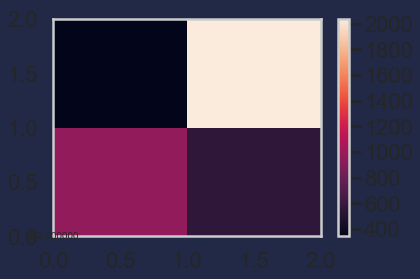

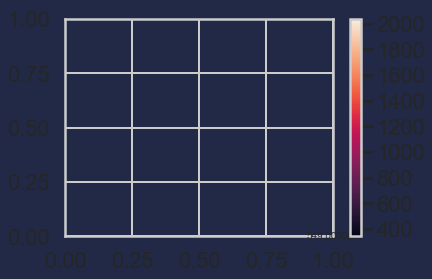

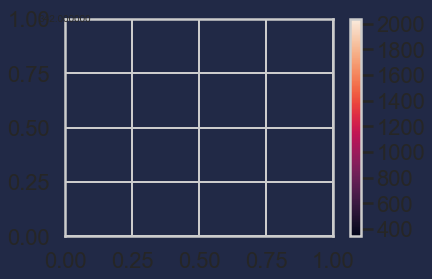

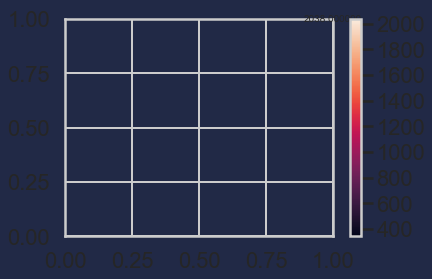

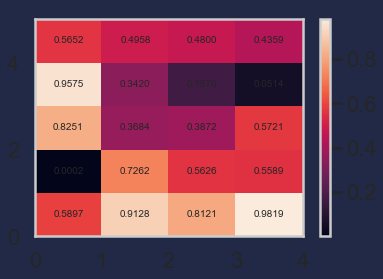

In [625]:
import matplotlib.pyplot as plt
import numpy as np

#ddata = np.random.rand(5, 4)
# display(type(ddata), ddata.dtype)
display(confusion_matrix_valAndAcronym)
# display(type(confusionMatrix_vals), confusionMatrix_vals.dtype)

display(confusionMatrix_vals)#confusionMatrix_vals.dtype,
confusionMatrix_valsObj#,confusionMatrix_valsObj.dtype,
confusionMatrix_acronym#,confusionMatrix_acronym.dtype,

array([[ 962,  549],
       [ 342, 2038]]
heatmap = plt.pcolor(confusionMatrix_vals)
for y in range(confusionMatrix_vals.shape[0]):
    for x in range(confusionMatrix_vals.shape[1]):
        #print('confusionMatrix_vals[y, x] returns: {}'.format(confusionMatrix_vals[y, x]))#, x]))
        """Add the text *s* to the axes at location *x*, *y* in data coordinates."""
        txt_obj = plt.text(x, y, '%f' % confusionMatrix_vals[y, x],
                           horizontalalignment='center', verticalalignment='center') #  
        #print(txt_obj)
        #sns.set_palette(heatmap)
        plt.colorbar(heatmap)
        plt.show()


ddata = np.random.rand(5, 4)
heatmap1 = plt.pcolor(ddata)

for y in range(ddata.shape[0]):
    for x in range(ddata.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % ddata[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

plt.colorbar(heatmap1)

#plt.show()

**5.2.2** _**TfidVectorizer()**_

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# word level tf-idf
tfidfVect = TfidfVectorizer(analyzer='word', 
                            token_pattern=r'\w{1,}',
                            max_features=5000)

# Train Vectorizer on ALL text features
tfidfVect.fit(train_df['x'])

# Transform training AND validation/test data 
# A sparse matrix of [n_samples, n_features]
# A Tf-idf-weighted document-term matrix is returned
xtrain_tfidfVect = tfidfVect.transform(train_x)
xtest_tfidfVect = tfidfVect.transform(test_x)

# Instantiate a Multi-Nomial Naive Bayes Classifier
model = MultinomialNB()
# Train model on train sets
model.fit(xtrain_tfidfVect, train_y)
# predict
predictions = model.predict(xtest_tfidfVect)
# evaluate prediction accuracy of model
print('Accuracy score w/ word weighted TF-IDF vectors for features: {}'\
      .format(round(accuracy_score(test_y,predictions),4)))

Accuracy score w/ word weighted TF-IDF vectors for features: 0.76


In [30]:
# ngram level tf-idf 
tfidfVect_ngram = TfidfVectorizer(analyzer='word',
                                  token_pattern=r'\w{1,}', 
                                  ngram_range=(2,3),
                                  max_features=5000)

# Train Vectorizer on ALL text features
tfidfVect_ngram.fit(train_df['x'])

# Transform training AND validation/test data into sparse matrices
# Returns A ngram-weighted Tf-idf document-term matrix of of [n_samples, n_features]
xtrain_ngramVect = tfidfVect_ngram.transform(train_x)
xtest_ngramVect = tfidfVect_ngram.transform(test_x)

# Instantiate Naive Bayes classifier
model = MultinomialNB()
# Train
model.fit(xtrain_ngramVect, train_y)
# predict
predictions = model.predict(xtest_ngramVect)
# evaluate model accuracy
print('Accuracy score w/ ngram weighted Tf-idf vectors for features: {}'\
      .format(round(accuracy_score(test_y, predictions),4)))

Accuracy score w/ ngram weighted Tf-idf vectors for features: 0.6937


In [31]:
# characters level tf-idf
tfidfVect_NgramChars = TfidfVectorizer(analyzer='char',
                                        token_pattern=r'\w{1,}',
                                        ngram_range=(2,3),
                                        max_features=5000)
# Train Vectorizer on ALL text features
tfidfVect_NgramChars.fit(train_df['x'])

# Transform train/test data into sparse matrices
# Returns char-weighted Tf-idf doc-term matrix: [n_samples, n_features]
xtrain_ngramCharVect = tfidfVect_NgramChars.transform(train_x) 
xtest_ngramCharVect = tfidfVect_NgramChars.transform(test_x) 

# Instantiate Naive Bayes classifier
model = MultinomialNB()
# Train
model.fit(xtrain_ngramCharVect, train_y)
# predict
predictions = model.predict(xtest_ngramCharVect)
# evaluate model accuracy
print('Accuracy score: character weighted Tf-idf vectors for features:\
{}\n\n'.format(round(accuracy_score(test_y, predictions),4)))

Accuracy score: character weighted Tf-idf vectors for features:0.6916




**5.2.2** _**TfidVectorizer() using Pipeline**_

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# Example #0: Using a pipeline w/ TF-IDF and MultiNomial Naive Bayes
piped_multiNomNB0_0 = make_pipeline(TfidfVectorizer(), MultinomialNB())
model0_0_label_preds = piped_multiNomNB0_0.fit(train_x, train_y).predict(test_x)
print('model "0_0"\n\n')
#print(_.format(round(accuracy_score(test_y, model0_0_label_preds),4)))

# Now w/ manual cross-validation (2 folds) on model0_0 seen above
piped_multiNomNB0_0 = make_pipeline(TfidfVectorizer(), MultinomialNB())
model0_1_label_preds = piped_multiNomNB0_0.fit(train_x, train_y).predict(test_x)
model0_2_label_preds = piped_multiNomNB0_0.fit(test_x, test_y).predict(train_x)
_ = 'Accuracy score after cross-validation (2-folds):\n\
model "0_1" score: %.4f\n\
model "0_2" score: %.4f'
print(_%(accuracy_score(test_y, model0_1_label_preds), 
         accuracy_score(train_y, model0_2_label_preds)))

print('Avg score of folds: %.4f\n\n' % round(((((accuracy_score(test_y,model0_1_label_preds)*100)+\
                                                (accuracy_score(train_y, model0_2_label_preds)*100))/2)*.01),4))

# model1_0  w/ manual cross-validation (2 folds)
piped_multiNomNB1_0 = make_pipeline(TfidfVectorizer(analyzer='word',token_pattern=r'\w{1,}'),
                                    MultinomialNB())
model1_1_label_preds = piped_multiNomNB1_0.fit(train_x, train_y).predict(test_x)
model1_2_label_preds = piped_multiNomNB1_0.fit(test_x, test_y).predict(train_x)
_ = 'model "1_0"\n\nAccuracy score after Cross-Validation (2-folds):\n\
model "1_1" score: %.4f\n\
model "1_2" score: %.4f'
print(_%(accuracy_score(test_y, model1_1_label_preds), 
         accuracy_score(train_y, model1_2_label_preds)))

print('Avg score of folds: %.4f' % round(((((accuracy_score(test_y, model1_1_label_preds)*100)+\
                                            (accuracy_score(train_y, model1_2_label_preds)*100))/2)*.01),4))

NameError: name 'TfidfVectorizer' is not defined

___
**Visualize model performance with error matrix**
___
#Evaluate performance given predictions w/ error matrix

model1_1_error_matrix = confusion_matrix(test_y,
                                         model1_1_label_preds)
                                         
sns.heatmap(model1_1_error_matrix.T, square=True, annot=True, fmt='d',
            cbar=False, xticklabels=train_y.values, yticklabels=train_y.values)
            
plt.xlabel('true label'); plt.ylabel('predicted label (model(1_1))'); plt.show()

model1_2_error_matrix = confusion_matrix(test_y,
                                         model1_2_label_preds)
                                         
sns.heatmap(model1_2_error_matrix.T, square=True, annot=True, fmt='d',
            cbar=False,xticklabels=train_y.values, yticklabels=train_y.values)
            
plt.xlabel('true label'); plt.ylabel('predicted label (model1_2)');

print('The matrix displays the true labels and the model's label predictions.')
____

In [ ]:
# simple function to build/evaluate model(s)
def BuildModelandScore(model, xtrain_vector, y_train, xtest_vector):
    model.fit(xtrain_vector, y_train)   
    predictions = model.predict(xtest_vector)
    return accuracy_score(test_y, predictions)

In [ ]:
# Naive Bayes on Count Vectors  -----------------
# Naive Bayes on Word Level TF IDF Vectors      |
# Naive Bayes on Ngram Level TF IDF Vectors     |----> "outcomes" 
# NB on Character Level TF IDF Vectors ---------|

outcomes_dict = {'NBcountVect_accuracy' : BuildModelandScore(MultinomialNB(), xtrain_countVect, train_y, xtest_countVect),
                 'NBwordLevel_accuracy' : BuildModelandScore(MultinomialNB(), xtrain_tfidfVect, train_y, xtest_tfidfVect),
                 'NBnGramLevel_accuracy' : BuildModelandScore(MultinomialNB(), xtrain_ngramVect, train_y, xtest_ngramVect),
                 'NBCharLevel_accuracy' : BuildModelandScore(MultinomialNB(), xtrain_ngramCharVect, train_y, xtest_ngramCharVect)}
outcomes = pd.Series(outcomes_dict)
display(outcomes)
plt.figure(facecolor='lightgrey', figsize=(9,6))
chart = outcomes.plot.bar()
plt.title('Accuracy Scores for Multinomial NB Classifiers')
plt.xlabel('models'), plt.ylabel('Accuracy Score')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

### Hyperparameter tuning for Naive Bayes (and text maintenance)

- We need to know what value to use for $\alpha$
- We also need to know which words to include in the vocabulary. As mentioned earlier ... for example:
    - Some words are obvious stopwords.
    - (in addition to stopwords) Some words appear so frequently that they may also serve as noise.
    - Other words appear so infrequently that they serve as noise.    

#### Finding "min_df" for CountVectorizer()
`min_df` can be either an integer or a float/decimal, therefor, 
 - If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary.
  - If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary:

>"min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None." - Docs

### Construct the CDF for document frequencies (df)

**_For Example_**: The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For instance: $x=5$. Below I will at plot a point representing the percentage (float) or number (as an integer) of words that appear in 5 or fewer documents.
   
   >>>**Find the point at which the curve begins climbing steeply ... This may be a good value for `min_df`.**

#### **"max_df"**
   - If we were interested in also picking `max_df`, our task is to pick the value where the curve starts to plateau.

In [ ]:
#CountVect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
#vect.fit(train_df['x'])
#xtrain_countVect =  CountVect.transform(train_x)
#xtest_countVect =  CountVect.transform(test_x)

""" vect = CountVectorizer(min_df=0., max_df=1.0)
X = vect.fit_transform(docs)
print(DataFrame(X.A, columns=vect.get_feature_names()).to_string())"""

train_df['x'].values
train_x_list = list(train_x.values)

In [ ]:
print('train_x size=', train_x.size)
train_x_list_ = train_x.to_list()
print('train_x_list length= {}'.format(len(train_x_list)))

# trainXlist_tostring = str(train_x_list).split(", '")
# print('train_x_list_tostring= {}'.format(len(trainXlist_tostring)))

# str_snip = xtrainlist_string[0:4]
# str_snip
# display(str_snip)
# len(str_snip.split(", '"))
# xtrain_list[0]
# xtrainlist_string[0:64]

In [ ]:
"""example"""
# texts = ['hi there', 'hello there', 'hello there you are']
# len(texts)
# vect = CountVectorizer(min_df=0., max_df=1.0)
# X = vect.fit_transform(train_x_list) #train_df['x']
# display(X.A)
# feature_names = vect.get_feature_names()
print(pd.DataFrame(X.A, columns=feature_names).to_string()[5])
# print(pd.DataFrame(X.A, columns=vect.get_feature_names()).to_string())



In [ ]:
import nltk
from nltk import FreqDist

texts = 'hi there hello there'
words = nltk.tokenize.word_tokenize(texts)
fdist = FreqDist(words)

In [ ]:
texts = ['hi there', 'hello there', 'hello here you are']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)
freq = np.ravel(X.sum(axis=0)) # sum each columns to get total counts for each word

import operator
# get vocabulary keys, sorted by value
vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
fdist = dict(zip(vocab, freq)) # return same format as nltk

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [ ]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [ ]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

In [ ]:
log_likelihood(MultinomialNB(), )

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [ ]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [ ]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = None # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn

In [ ]:
print("alpha: {}".format(best_alpha))

<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [ ]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [ ]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [ ]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [ ]:
#your turn

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [ ]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [ ]:
# Your turn